In [1]:
import pandas as pd
import numpy as np

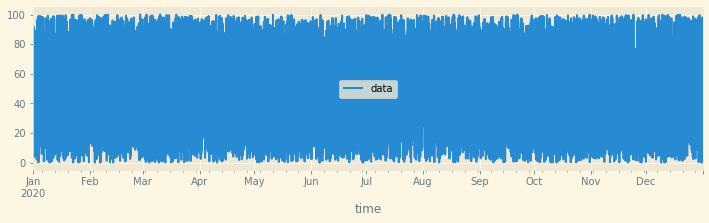

In [14]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('Solarize_Light2')


data = final
df = pd.DataFrame(columns=['time', 'data'])
df['time'] = final.date
df['data'] = final.cpu
df = df.set_index('time')
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
pred = test.copy()
df.plot(figsize=(12,3));

df['z_data'] = (df['data'] - df.data.rolling(window=12).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.data.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

In [15]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?


MissingDataError: exog contains inf or nans

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=20)

In [ ]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np
%matplotlib inline
plt.style.use('Solarize_Light2')

df = pd.DataFrame(columns=['time', 'data'])
df['time'] = final.date
df['data'] = final.cpu
df = df.set_index('time')

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.30, shuffle=False)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

model = ExponentialSmoothing(np.asarray(train['data']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['data']), trend='mul', seasonal=None, damped=True)
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(9)
pred2 = fit2.forecast(10)

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index[250:], train.values[250:])
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index[300:], train.values[300:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index[250:], f.fittedvalues[250:], color=c)
    ax[1].plot(train.index[300:], f.fittedvalues[300:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(df.data.values);
ax[0].set_title("Raw data");
ax[1].plot(np.log(df.data.values));
ax[1].set_title("Logged data (deflated)");
ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(df.data)- np.log(df.data).shift()).dropna()
ax[0, 0] = plot_acf(np.log(df.data), ax=ax[0, 0], lags=20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(df.data), ax=ax[1, 0], lags=20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


model = sm.tsa.arima.ARIMA(df.data, (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = sm.tsa.arima.ARIMA(np.log(df.data).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();